#### Install and import packages

In [ ]:
!pip install neuraloperator
!pip install tensorly
!pip install tensorly-torch
!pip install wandb
!pip install zarr
!pip install torch-harmonics

In [ ]:
from scipy.io import loadmat
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
from neuralop.models import FNO2d
import matplotlib.pyplot as plt
from neuralop import LpLoss, H1Loss
import wandb

#### Login to wandb platform

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Initialise project and log the configuration of model

In [ ]:
# 'hyperparameters' is a dictionary containing your hyperparameters, for example:
hyperparameters = {
    "learning_rate": 0.0001,
    "batch_size": 1,
    "epochs": 300,
    "scheduler": "LinearLR",
    "end point": 0.01,
    "iterations": 1800,
}
# Initialize a new wandb run
wandb.init(project="part6-training", name="retraining but normalizing rest to first channel and epoch 300, 1800 iter", config=hyperparameters)

#### Import data

In [ ]:
case_k_params = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_params_normalized/case_k_params_normalized.pt")
case_w_params = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_params_normalized/case_w_params_normalized.pt")
case_sig_params = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_params_normalized/case_sig_params_normalized.pt")
case_k = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_pt/case_k.pt")
case_w = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_pt/case_w.pt")
case_sig = torch.load("/content/drive/MyDrive/SEGP/data_SEGP/batch_2_pt/case_sig.pt")

In [ ]:
if torch.cuda.is_available:
    print("CUDA is available. Running on GPU.")
else:
    print("CUDA is unavailable. Running on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available. Running on GPU.


#### Data processing

In [ ]:
case_k = case_k.tolist()
case_w = case_w.tolist()
case_sig = case_sig.tolist()
case_k_params = case_k_params.tolist()
case_w_params = case_w_params.tolist()
case_sig_params = case_sig_params.tolist()

# deleting the first image from all of them
for i in range(len(case_k)):
    case_k[i].pop(0)
    case_w[i].pop(0)
    case_sig[i].pop(0)
    case_k_params[i].pop(0)
    case_w_params[i].pop(0)
    case_sig_params[i].pop(0)

# seperating the test from the training
data_test = []
data_train = []
data_test_params = []
data_train_params = []

for i in range(5):
    if i != 2:
        data_train.append(case_k[i])
        data_train.append(case_w[i])
        data_train.append(case_sig[i])
        data_train_params.append(case_k_params[i])
        data_train_params.append(case_w_params[i])
        data_train_params.append(case_sig_params[i])
    else:
        data_test.append(case_k[i])
        data_test.append(case_w[i])
        data_test.append(case_sig[i])
        data_test_params.append(case_k_params[i])
        data_test_params.append(case_w_params[i])
        data_test_params.append(case_sig_params[i])

In [ ]:
# split the data into X and y targets for both training and testing
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(len(data_train)):
    X = []
    y = []
    for j in range(len(data_train[i]) - 1):
        X.append(data_train_params[i][j])
        y.append(data_train[i][j+1])
    X_train.append(X)
    y_train.append(y)

for i in range(len(data_test)):
    X = []
    y = []
    for j in range(len(data_test[i]) - 1):
        X.append(data_test_params[i][j])
        y.append(data_test[i][j+1])
    X_test.append(X)
    y_test.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train).to(torch.float).to(device)
X_test = torch.tensor(X_test).to(torch.float).to(device)
y_train = torch.tensor(y_train).to(torch.float).to(device)
y_test = torch.tensor(y_test).to(torch.float).to(device)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([12, 119, 4, 101, 101]),
 torch.Size([12, 119, 1, 101, 101]),
 torch.Size([3, 119, 4, 101, 101]),
 torch.Size([3, 119, 1, 101, 101]))

#### Tensor plotting function

In [ ]:
# function to plot images

def plotImage(x, index, message):
    # plt.title(f"Time={sample1 * 5}")

    vmin = 0  # Minimum temperature value
    vmax = 80  # Maximum temperature value

    heatmap = plt.imshow(x.squeeze().detach().cpu().numpy(), cmap='inferno', interpolation='nearest')
    plt.colorbar(label='Temperature (°C)')
    heatmap.set_clim(vmin, vmax)  # Set the colorbar scale explicitly
    plt.axis(False)
    plt.title(f"{message} at time={index * 5}")

#### Initialize Dataset class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, torch.Tensor):
            self.X = X.clone().detach()
        else:
            self.X = torch.tensor(X)

        if isinstance(y, torch.Tensor):
            self.y = y.clone().detach()
        else:
            self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Encoding channels 2-4 to output tensor

In [ ]:
def addChannels(tensor, k_val, w_val, sig_val):
    extra_channels = np.stack((np.full((101, 101), k_val), np.full((101, 101), w_val), np.full((101, 101), sig_val)), axis=0)
    extra_channels_reshaped = extra_channels.reshape(1, 3, 101, 101)
    extra_channels_repeated = np.repeat(extra_channels_reshaped, tensor.shape[0], axis=0)
    tensor = tensor.cpu().detach().numpy()
    final_array = np.concatenate((tensor, extra_channels_repeated), axis=1)
    final_tensor = torch.tensor(final_array, dtype=torch.float32).cuda()
    return final_tensor

#### Initilising model, loss function, optimiser, and scheduler

In [ ]:
model = FNO2d(n_modes_height=32, n_modes_width=32, hidden_channels=32, projection_channels=101,
                in_channels=4, out_channels=1).to(device)
loss_fn = H1Loss(d=2)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=1800)

#### Training loop

In [ ]:
epochs = 300
prediction_length = 100
best_model_params = None

lowest_loss = float('inf')
for epoch in range(epochs):
    model.train()

    total_rmse_loss = 0
    total_train_loss = 0
    for sequence_inputs, sequence_outputs in train_dataloader:

        sequence_inputs = sequence_inputs.squeeze(0)
        sequence_outputs = sequence_outputs.squeeze(0)

        input_sample = sequence_inputs[0].unsqueeze(0)

        k_val = round(input_sample[0][1][0][0].item(), 4)
        w_val = round(input_sample[0][2][0][0].item(), 4)
        sig_val = round(input_sample[0][3][0][0].item(), 4)
        params_tensor = torch.tensor([[k_val, w_val, sig_val]]).view(1, 3, 1, 1).expand(-1, -1, 101, 101).to(device)

        for i in range(sequence_inputs.shape[0]):
            prediction = model(input_sample)
            truth = sequence_outputs[i].unsqueeze(0)

            optimizer.zero_grad()

            loss = loss_fn(prediction, truth)

            loss.backward()

            total_train_loss += loss.item()
            rmse = torch.sqrt(torch.mean((prediction - truth) ** 2))
            total_rmse_loss += rmse.item()

            optimizer.step()

            prediction = prediction.detach()
            input_sample = torch.cat((prediction, params_tensor), dim=1)

        scheduler.step()

    avg_train_loss = total_train_loss/len(train_dataloader)
    avg_rmse_loss = total_rmse_loss/(sequence_inputs.shape[0] * len(train_dataloader))

    wandb.log({"epoch": epoch,"avg_train_loss": avg_train_loss, "avg_rmse_loss": avg_rmse_loss})

    if avg_train_loss < lowest_loss:
        lowest_loss = avg_train_loss
        best_model_params = model.state_dict()

    if epoch % 10 == 0 or epoch == epochs - 1:
        # test_acc = acc_fn(test_pred, y_test)
        print(f"Epoch: {epoch+1} | Avg Train Loss: {avg_train_loss:.5f} | Avg RMSE Loss: {avg_rmse_loss:.5f}")
        print(f"Lowest training loss: {lowest_loss:.5f}")

Epoch: 1 | Avg Train Loss: 78.11932 | Avg RMSE Loss: 8.21871
Lowest training loss: 78.11932
Epoch: 11 | Avg Train Loss: 77.07544 | Avg RMSE Loss: 7.07449
Lowest training loss: 76.88214
Epoch: 21 | Avg Train Loss: 77.17507 | Avg RMSE Loss: 7.26136
Lowest training loss: 76.88214
Epoch: 31 | Avg Train Loss: 76.04152 | Avg RMSE Loss: 7.19410
Lowest training loss: 76.04152
Epoch: 41 | Avg Train Loss: 69.87167 | Avg RMSE Loss: 6.57224
Lowest training loss: 69.87167
Epoch: 51 | Avg Train Loss: 66.42390 | Avg RMSE Loss: 6.81717
Lowest training loss: 61.10514
Epoch: 61 | Avg Train Loss: 42.35066 | Avg RMSE Loss: 4.35236
Lowest training loss: 41.50108
Epoch: 71 | Avg Train Loss: 38.13153 | Avg RMSE Loss: 4.09461
Lowest training loss: 29.82161
Epoch: 81 | Avg Train Loss: 46.97961 | Avg RMSE Loss: 4.90750
Lowest training loss: 27.05829
Epoch: 91 | Avg Train Loss: 31.72770 | Avg RMSE Loss: 3.40604
Lowest training loss: 27.05829
Epoch: 101 | Avg Train Loss: 32.41244 | Avg RMSE Loss: 3.40316
Lowest t

#### Load best parameters to model

In [ ]:
model.load_state_dict(best_model_params)

<All keys matched successfully>

#### Finish logging information

In [ ]:
wandb.watch(model)
wandb.finish()

avg_rmse_loss,██████▇▅▄▄▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_train_loss,██████▇▅▃▄▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
avg_rmse_loss,0.96834
avg_train_loss,5.1844
epoch,299


#### Saving model to Drive

In [ ]:
import os

directory = "/content/drive/MyDrive/SEGP/SEGP_models/LCAN-SIMM-FNO3"

# Specify the filename for your model
filename = "FNO-11.pth"

# Full path for saving the model
full_path = os.path.join(directory, filename)

# Check if the specified directory exists, create it if it does not
if not os.path.exists(directory):
    os.makedirs(directory)

# saving the paramaters of the model, not the model itself
torch.save(model.state_dict(), full_path)

#### Visualize models prediction

In [ ]:
test_sample = X_test[1][5]
test_sample.shape

torch.Size([4, 101, 101])

In [ ]:
prediction = test_sample.unsqueeze(0)
k_val = prediction[0][1][0][0].item()
w_val = round(prediction[0][2][0][0].item(), 4)
sig_val = round(prediction[0][3][0][0].item(), 4)

In [ ]:
prediction = prediction.float()
simulation = []
model.eval()
with torch.inference_mode():
    for i in range(100):
        input = prediction
        prediction = model(input)
        simulation.append(prediction)
        prediction = addChannels(prediction, k_val, w_val, sig_val)

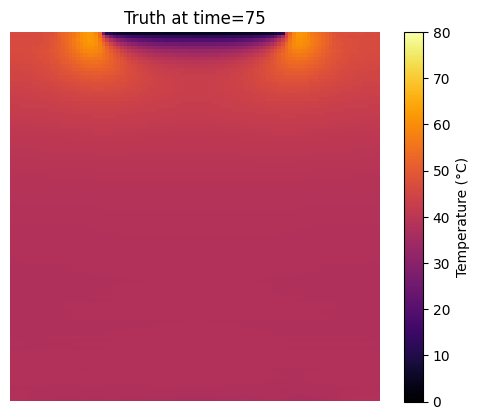

In [ ]:
plotImage(simulation[94], 15, "Truth")

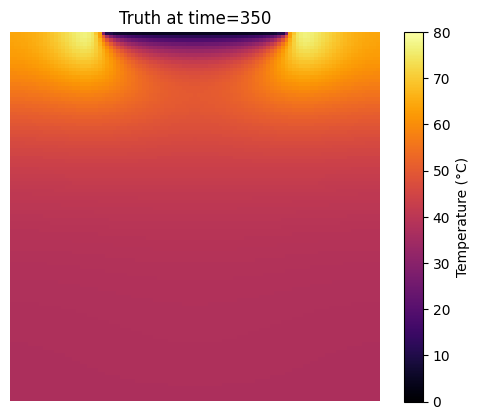

In [ ]:
plotImage(y_test[1][99], 70, "Truth")